<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/Fish_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
run = 1
seed = 1617 * run
np.random.seed(seed)

In [4]:
from sklearn import preprocessing

def load_data(dataset="Fish"):
    folder = '' # folder = '../data/matlab/'
    mat = scipy.io.loadmat(folder + dataset + '.mat')
    X = mat['X']
    X = X.astype(float)
    y = mat['Y']
    y = y[:, 0]
    return X,y 

def get_labels(y):
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y_ = le.transform(y)
    labels = le.inverse_transform(np.unique(y_))
    return y_, labels

dataset = "Fish"
X,y = load_data(dataset=dataset)
y_, labels = get_labels(y)

In [6]:
inc = 50
no_features = X.shape[1] + inc
j = np.arange(inc,no_features,inc) # [50,4800]

In [7]:
from skfeature.function.similarity_based import reliefF
from skfeature.function.information_theoretical_based import MRMR
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC as svm

methods = { "reliefF" : reliefF.reliefF, "mrmr": MRMR.mrmr, "chi2": chi2}
results = { "reliefF" : [], "mrmr": [], "chi2": [], "pso": []}
penalty = 'l1'

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

def normalize(X_train, X_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [9]:
import Problem
import PSO

def pso(X,y):
    prob = Problem.FeatureSelection(minimized=True, X=X, y=y)
    pop_size = 30
    n_iterations = 100
    no_fea = X.shape[1]
    swarm = PSO.Swarm(n_particle=pop_size, length=no_fea, n_iterations=n_iterations,
                        max_pos=1.0, min_pos=0.0, max_vel=0.2, min_vel=-0.2,
                        problem=prob)
    best_sol, best_fit = swarm.iterate()
    sel_fea = np.where(best_sol > prob.threshold)[0]
    return sel_fea

In [10]:
runs = 30
name = "pso"
folds = 10

for k in tqdm(range(30)):
    train_accs = []
    test_accs = []
    skf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)

    for train, test in skf.split(X, y):
        X_train, X_test = (X[train], X[test])
        y_train, y_test = y[train], y[test]
        X_train, X_test = normalize(X_train, X_test)

        sel_fea = pso(X_train, y_train)

        model = svm()
        model.fit(X_train[:, sel_fea], y_train)

        y_predict = model.predict(X_train[:, sel_fea])
        train_acc = balanced_accuracy_score(y_train, y_predict)
        train_accs.append(train_acc)

        y_predict = model.predict(X_test[:, sel_fea])
        test_acc = balanced_accuracy_score(y_test, y_predict)
        test_accs.append(test_acc)

    no_fea = len(sel_fea)
    results[name].append((no_fea, np.mean(train_accs), np.mean(test_accs)))

100%|██████████| 30/30 [14:37:16<00:00, 1754.55s/it]


In [11]:
for k in tqdm(j):
    for name, fs_method in methods.items(): 
        if name == "pso":
          continue

        train_accs = []
        test_accs = []
        skf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)

        for train, test in skf.split(X, y):
            X_train, X_test = (X[train], X[test])
            y_train, y_test = y[train], y[test]
            X_train, X_test = normalize(X_train, X_test)

            fs = SelectKBest(fs_method, k=k)
            X_train = fs.fit_transform(X_train, y_train)
            X_test = fs.transform(X_test)

            model = svm()
            clf = model.fit(X_train, y_train)

            y_predict = model.predict(X_train)
            train_acc = balanced_accuracy_score(y_train, y_predict)
            train_accs.append(train_acc)
            y_predict = model.predict(X_test)
            test_acc = balanced_accuracy_score(y_test, y_predict)
            test_accs.append(test_acc)

        no_fea = k 
        results[name].append((no_fea, np.mean(train_accs), np.mean(test_accs)))

100%|██████████| 96/96 [2:24:29<00:00, 90.31s/it] 


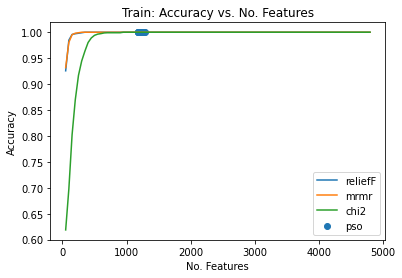

In [12]:
for name, result in results.items():
  k, train, test = zip(*result)
  if name == "pso":
    plt.scatter(k, train, label=name)
  else:
    plt.plot(k, train, label=name)

plt.title("Train: Accuracy vs. No. Features")
plt.xlabel("No. Features")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(fname=f"accuracy-features-{dataset}-train", dpi=500)
plt.show()

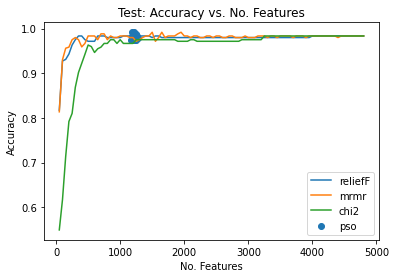

In [13]:
for name, result in results.items():
  k, train, test = zip(*result)
  if name == "pso":
    plt.scatter(k, test, label=name)
  else:
    plt.plot(k, test, label=name)

plt.title("Test: Accuracy vs. No. Features")
plt.xlabel("No. Features")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(fname=f"accuracy-features-{dataset}-test", dpi=500)
plt.show()

In [4]:
results = {'reliefF': [(50, 0.9256012529327343, 0.8172619047619047), (100, 0.9847375479613714, 0.9273809523809522), (150, 0.9957440100882724, 0.9309523809523809), (200, 0.9971153846153846, 0.9428571428571428), (250, 0.998076923076923, 0.9630952380952381), (300, 0.9990384615384615, 0.975), (350, 1.0, 0.9833333333333334), (400, 1.0, 0.9833333333333334), (450, 1.0, 0.975), (500, 1.0, 0.9714285714285715), (550, 1.0, 0.9714285714285715), (600, 1.0, 0.9714285714285715), (650, 1.0, 0.9833333333333334), (700, 1.0, 0.9833333333333334), (750, 1.0, 0.9833333333333334), (800, 1.0, 0.9797619047619047), (850, 1.0, 0.9797619047619047), (900, 1.0, 0.9797619047619047), (950, 1.0, 0.9797619047619047), (1000, 1.0, 0.9797619047619047), (1050, 1.0, 0.9833333333333334), (1100, 1.0, 0.9833333333333334), (1150, 1.0, 0.9833333333333334), (1200, 1.0, 0.9833333333333334), (1250, 1.0, 0.9833333333333334), (1300, 1.0, 0.9833333333333334), (1350, 1.0, 0.9833333333333334), (1400, 1.0, 0.9833333333333334), (1450, 1.0, 0.9833333333333334), (1500, 1.0, 0.9797619047619047), (1550, 1.0, 0.9833333333333334), (1600, 1.0, 0.9833333333333334), (1650, 1.0, 0.9797619047619047), (1700, 1.0, 0.9797619047619047), (1750, 1.0, 0.9797619047619047), (1800, 1.0, 0.9797619047619047), (1850, 1.0, 0.9797619047619047), (1900, 1.0, 0.9797619047619047), (1950, 1.0, 0.9797619047619047), (2000, 1.0, 0.9797619047619047), (2050, 1.0, 0.9797619047619047), (2100, 1.0, 0.9797619047619047), (2150, 1.0, 0.9797619047619047), (2200, 1.0, 0.9797619047619047), (2250, 1.0, 0.9797619047619047), (2300, 1.0, 0.9797619047619047), (2350, 1.0, 0.9797619047619047), (2400, 1.0, 0.9797619047619047), (2450, 1.0, 0.9797619047619047), (2500, 1.0, 0.9797619047619047), (2550, 1.0, 0.9797619047619047), (2600, 1.0, 0.9797619047619047), (2650, 1.0, 0.9797619047619047), (2700, 1.0, 0.9797619047619047), (2750, 1.0, 0.9797619047619047), (2800, 1.0, 0.9797619047619047), (2850, 1.0, 0.9797619047619047), (2900, 1.0, 0.9797619047619047), (2950, 1.0, 0.9797619047619047), (3000, 1.0, 0.9797619047619047), (3050, 1.0, 0.9797619047619047), (3100, 1.0, 0.9797619047619047), (3150, 1.0, 0.9797619047619047), (3200, 1.0, 0.9797619047619047), (3250, 1.0, 0.9797619047619047), (3300, 1.0, 0.9797619047619047), (3350, 1.0, 0.9797619047619047), (3400, 1.0, 0.9797619047619047), (3450, 1.0, 0.9797619047619047), (3500, 1.0, 0.9797619047619047), (3550, 1.0, 0.9797619047619047), (3600, 1.0, 0.9797619047619047), (3650, 1.0, 0.9797619047619047), (3700, 1.0, 0.9797619047619047), (3750, 1.0, 0.9797619047619047), (3800, 1.0, 0.9797619047619047), (3850, 1.0, 0.9797619047619047), (3900, 1.0, 0.9797619047619047), (3950, 1.0, 0.9797619047619047), (4000, 1.0, 0.9833333333333334), (4050, 1.0, 0.9833333333333334), (4100, 1.0, 0.9833333333333334), (4150, 1.0, 0.9833333333333334), (4200, 1.0, 0.9833333333333334), (4250, 1.0, 0.9833333333333334), (4300, 1.0, 0.9833333333333334), (4350, 1.0, 0.9833333333333334), (4400, 1.0, 0.9833333333333334), (4450, 1.0, 0.9833333333333334), (4500, 1.0, 0.9833333333333334), (4550, 1.0, 0.9833333333333334), (4600, 1.0, 0.9833333333333334), (4650, 1.0, 0.9833333333333334), (4700, 1.0, 0.9833333333333334), (4750, 1.0, 0.9833333333333334), (4800, 1.0, 0.9833333333333334)], 'mrmr': [(50, 0.9317704487116089, 0.8136904761904761), (100, 0.9806371614216411, 0.9303571428571429), (150, 0.9951923076923077, 0.9559523809523809), (200, 0.9981456043956044, 0.9583333333333333), (250, 0.9990384615384615, 0.975), (300, 1.0, 0.9797619047619047), (350, 1.0, 0.975), (400, 1.0, 0.9589285714285716), (450, 1.0, 0.9666666666666666), (500, 1.0, 0.9833333333333334), (550, 1.0, 0.9833333333333334), (600, 1.0, 0.9833333333333334), (650, 1.0, 0.975), (700, 1.0, 0.9880952380952381), (750, 1.0, 0.9880952380952381), (800, 1.0, 0.975), (850, 1.0, 0.9833333333333334), (900, 1.0, 0.9797619047619047), (950, 1.0, 0.9797619047619047), (1000, 1.0, 0.9833333333333334), (1050, 1.0, 0.9833333333333334), (1100, 1.0, 0.9833333333333334), (1150, 1.0, 0.9797619047619047), (1200, 1.0, 0.9797619047619047), (1250, 1.0, 0.9714285714285715), (1300, 1.0, 0.975), (1350, 1.0, 0.9797619047619047), (1400, 1.0, 0.9833333333333334), (1450, 1.0, 0.9833333333333334), (1500, 1.0, 0.9916666666666666), (1550, 1.0, 0.9714285714285715), (1600, 1.0, 0.9797619047619047), (1650, 1.0, 0.9916666666666666), (1700, 1.0, 0.9797619047619047), (1750, 1.0, 0.9833333333333334), (1800, 1.0, 0.9833333333333334), (1850, 1.0, 0.9833333333333334), (1900, 1.0, 0.9880952380952381), (1950, 1.0, 0.9916666666666666), (2000, 1.0, 0.9833333333333334), (2050, 1.0, 0.9833333333333334), (2100, 1.0, 0.9797619047619047), (2150, 1.0, 0.9833333333333334), (2200, 1.0, 0.9833333333333334), (2250, 1.0, 0.9797619047619047), (2300, 1.0, 0.9797619047619047), (2350, 1.0, 0.9833333333333334), (2400, 1.0, 0.9833333333333334), (2450, 1.0, 0.9797619047619047), (2500, 1.0, 0.9833333333333334), (2550, 1.0, 0.9833333333333334), (2600, 1.0, 0.9797619047619047), (2650, 1.0, 0.9797619047619047), (2700, 1.0, 0.9833333333333334), (2750, 1.0, 0.9833333333333334), (2800, 1.0, 0.9797619047619047), (2850, 1.0, 0.9797619047619047), (2900, 1.0, 0.9797619047619047), (2950, 1.0, 0.9833333333333334), (3000, 1.0, 0.9797619047619047), (3050, 1.0, 0.9797619047619047), (3100, 1.0, 0.9797619047619047), (3150, 1.0, 0.9833333333333334), (3200, 1.0, 0.9833333333333334), (3250, 1.0, 0.9833333333333334), (3300, 1.0, 0.9797619047619047), (3350, 1.0, 0.9833333333333334), (3400, 1.0, 0.9833333333333334), (3450, 1.0, 0.9797619047619047), (3500, 1.0, 0.9833333333333334), (3550, 1.0, 0.9833333333333334), (3600, 1.0, 0.9833333333333334), (3650, 1.0, 0.9833333333333334), (3700, 1.0, 0.9797619047619047), (3750, 1.0, 0.9833333333333334), (3800, 1.0, 0.9833333333333334), (3850, 1.0, 0.9833333333333334), (3900, 1.0, 0.9797619047619047), (3950, 1.0, 0.9833333333333334), (4000, 1.0, 0.9833333333333334), (4050, 1.0, 0.9833333333333334), (4100, 1.0, 0.9833333333333334), (4150, 1.0, 0.9833333333333334), (4200, 1.0, 0.9833333333333334), (4250, 1.0, 0.9833333333333334), (4300, 1.0, 0.9833333333333334), (4350, 1.0, 0.9833333333333334), (4400, 1.0, 0.9797619047619047), (4450, 1.0, 0.9833333333333334), (4500, 1.0, 0.9833333333333334), (4550, 1.0, 0.9833333333333334), (4600, 1.0, 0.9833333333333334), (4650, 1.0, 0.9833333333333334), (4700, 1.0, 0.9833333333333334), (4750, 1.0, 0.9833333333333334), (4800, 1.0, 0.9833333333333334)], 'chi2': [(50, 0.6186477119395922, 0.549404761904762), (100, 0.6982326582482068, 0.6172619047619048), (150, 0.8019852213246839, 0.7139880952380951), (200, 0.8696182839598878, 0.7919642857142856), (250, 0.9168426909446298, 0.8101190476190476), (300, 0.9445019227068207, 0.8684523809523809), (350, 0.963454584360391, 0.9017857142857142), (400, 0.9801970437170354, 0.9220238095238095), (450, 0.9890046518252495, 0.9422619047619047), (500, 0.9940380910733898, 0.9630952380952381), (550, 0.9963710040620406, 0.9595238095238094), (600, 0.9973325425235791, 0.9464285714285714), (650, 0.9986352357320099, 0.9547619047619047), (700, 0.9990384615384615, 0.9583333333333333), (750, 0.9990384615384615, 0.9666666666666666), (800, 0.9990384615384615, 0.9666666666666666), (850, 0.9990384615384615, 0.975), (900, 0.9990384615384615, 0.975), (950, 1.0, 0.9666666666666666), (1000, 1.0, 0.975), (1050, 1.0, 0.9666666666666666), (1100, 1.0, 0.9666666666666666), (1150, 1.0, 0.9666666666666666), (1200, 1.0, 0.9666666666666666), (1250, 1.0, 0.975), (1300, 1.0, 0.975), (1350, 1.0, 0.975), (1400, 1.0, 0.975), (1450, 1.0, 0.975), (1500, 1.0, 0.975), (1550, 1.0, 0.975), (1600, 1.0, 0.975), (1650, 1.0, 0.975), (1700, 1.0, 0.975), (1750, 1.0, 0.975), (1800, 1.0, 0.975), (1850, 1.0, 0.975), (1900, 1.0, 0.9714285714285715), (1950, 1.0, 0.9714285714285715), (2000, 1.0, 0.9714285714285715), (2050, 1.0, 0.9714285714285715), (2100, 1.0, 0.975), (2150, 1.0, 0.975), (2200, 1.0, 0.9714285714285715), (2250, 1.0, 0.9714285714285715), (2300, 1.0, 0.9714285714285715), (2350, 1.0, 0.9714285714285715), (2400, 1.0, 0.9714285714285715), (2450, 1.0, 0.9714285714285715), (2500, 1.0, 0.9714285714285715), (2550, 1.0, 0.9714285714285715), (2600, 1.0, 0.9714285714285715), (2650, 1.0, 0.9714285714285715), (2700, 1.0, 0.9714285714285715), (2750, 1.0, 0.9714285714285715), (2800, 1.0, 0.9714285714285715), (2850, 1.0, 0.9714285714285715), (2900, 1.0, 0.975), (2950, 1.0, 0.975), (3000, 1.0, 0.975), (3050, 1.0, 0.975), (3100, 1.0, 0.975), (3150, 1.0, 0.975), (3200, 1.0, 0.975), (3250, 1.0, 0.9833333333333334), (3300, 1.0, 0.9833333333333334), (3350, 1.0, 0.9833333333333334), (3400, 1.0, 0.9833333333333334), (3450, 1.0, 0.9833333333333334), (3500, 1.0, 0.9833333333333334), (3550, 1.0, 0.9833333333333334), (3600, 1.0, 0.9833333333333334), (3650, 1.0, 0.9833333333333334), (3700, 1.0, 0.9833333333333334), (3750, 1.0, 0.9833333333333334), (3800, 1.0, 0.9833333333333334), (3850, 1.0, 0.9833333333333334), (3900, 1.0, 0.9833333333333334), (3950, 1.0, 0.9833333333333334), (4000, 1.0, 0.9833333333333334), (4050, 1.0, 0.9833333333333334), (4100, 1.0, 0.9833333333333334), (4150, 1.0, 0.9833333333333334), (4200, 1.0, 0.9833333333333334), (4250, 1.0, 0.9833333333333334), (4300, 1.0, 0.9833333333333334), (4350, 1.0, 0.9833333333333334), (4400, 1.0, 0.9833333333333334), (4450, 1.0, 0.9833333333333334), (4500, 1.0, 0.9833333333333334), (4550, 1.0, 0.9833333333333334), (4600, 1.0, 0.9833333333333334), (4650, 1.0, 0.9833333333333334), (4700, 1.0, 0.9833333333333334), (4750, 1.0, 0.9833333333333334), (4800, 1.0, 0.9833333333333334)], 'pso': [(1211, 1.0, 0.975), (1206, 1.0, 0.9833333333333334), (1258, 1.0, 0.9833333333333334), (1192, 1.0, 0.9916666666666666), (1270, 1.0, 0.9797619047619047), (1216, 1.0, 0.9833333333333334), (1241, 1.0, 0.9880952380952381), (1214, 1.0, 0.9833333333333334), (1234, 1.0, 0.9797619047619047), (1243, 1.0, 0.975), (1180, 1.0, 0.975), (1178, 1.0, 0.975), (1216, 1.0, 0.9833333333333334), (1242, 1.0, 0.9833333333333334), (1217, 1.0, 0.9916666666666666), (1250, 1.0, 0.9833333333333334), (1213, 1.0, 0.9833333333333334), (1220, 1.0, 0.9833333333333334), (1240, 1.0, 0.9797619047619047), (1204, 1.0, 0.9833333333333334), (1217, 1.0, 0.975), (1245, 1.0, 0.9833333333333334), (1242, 1.0, 0.9833333333333334), (1242, 1.0, 0.9833333333333334), (1227, 1.0, 0.9797619047619047), (1249, 1.0, 0.9833333333333334), (1195, 1.0, 0.9797619047619047), (1178, 1.0, 0.9833333333333334), (1285, 1.0, 0.9797619047619047), (1174, 1.0, 0.975)]}

In [7]:
for method, result in results.items():
    k, train, test = list(zip(*result))
    best_k = np.argmax(test)
    print(f"{method} performed best at {k[best_k]} features, with {train[best_k]} training accuracy, and {test[best_k]} test accuracy.")

k, train, test = results['mrmr'][-1]
print(f"Full-dataset with {k} features, with {train} training accuracy, and {test} test accuracy.")

reliefF performed best at 350 features, with 1.0 training accuracy, and 0.9833333333333334 test accuracy.
mrmr performed best at 1500 features, with 1.0 training accuracy, and 0.9916666666666666 test accuracy.
chi2 performed best at 3250 features, with 1.0 training accuracy, and 0.9833333333333334 test accuracy.
pso performed best at 1192 features, with 1.0 training accuracy, and 0.9916666666666666 test accuracy.
Full-dataset with 4800 features, with 1.0 training accuracy, and 0.9833333333333334 test accuracy.


In [14]:
from prettytable import PrettyTable

def show_results(results, label='Method'):
    table = PrettyTable([label, 'Best K', 'Train', 'Test'])

    for name, result in results.items():
        k, train, test = list(zip(*result))
        best_k = np.argmax(test)
        vals = [k[best_k], train[best_k], test[best_k]]
        row = ['%.4f' % elem if i != 0 else elem for i, elem in enumerate(vals) ]
        table.add_row(np.concatenate([[name], row]))

    k, train, test = results['mrmr'][-1]
    vals = [k, train, test]
    row = ['%.4f' % elem if i != 0 else elem for i, elem in enumerate(vals) ]
    table.add_row(np.concatenate([['full'], row]))

    print('\n') # tqdm messses with table border.
    print(table)

show_results(results)



+---------+--------+--------+--------+
|  Method | Best K | Train  |  Test  |
+---------+--------+--------+--------+
| reliefF |  350   | 1.0000 | 0.9833 |
|   mrmr  |  1500  | 1.0000 | 0.9917 |
|   chi2  |  3250  | 1.0000 | 0.9833 |
|   pso   |  1192  | 1.0000 | 0.9917 |
|   full  |  4800  | 1.0000 | 0.9833 |
+---------+--------+--------+--------+
